In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2
import seaborn as sns

In [136]:
datasets = ["DTD","EuroSAT","GTSRB","MNIST","SVHN","Caltech256"]
nrow, ncol=2, 3
margin = 0.02

In [137]:
def eval_pred(pred):
    results = []
    for col in pred.columns.drop("target"):
        acc = (pred[col] == pred["target"]).mean()
        results.append({"Method": col, "Accuracy": acc})
    return pd.DataFrame(results)
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
def cons_weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

def barplot(pred, ds, ax):
    results_df = eval_pred(pred)
    
    sns.barplot(x='Method', y='Accuracy', data=results_df, ax=ax)
    
    pred101_acc = results_df.loc[results_df['Method'] == 'pred101', 'Accuracy'].values[0]
    pred18_acc = results_df.loc[results_df['Method'] == 'pred18', 'Accuracy'].values[0]
    
    baseline_acc = max(pred101_acc, pred18_acc)
    baseline_method = 'pred101' if baseline_acc == pred101_acc else 'pred18'
    
    ax.axhline(y=baseline_acc, color='r', linestyle='--')
    ax.text(len(results_df) - 1, baseline_acc, f"Baseline ({baseline_method}): {baseline_acc:.2%}", color='r', ha='center', va='bottom')
    
    for index, row in results_df.iterrows():
        ax.text(index, row['Accuracy'], f"{row['Accuracy']:.2%}", color='black', ha="center")
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'Ensemble Accuracy on {ds}')
    ax.set_xlabel('Ensembling Method')
    ax.set_ylabel('Accuracy')
    
    min_acc = results_df['Accuracy'].min()
    max_acc = results_df['Accuracy'].max()
    ax.set_ylim(min_acc - margin, min(1, max_acc + margin))

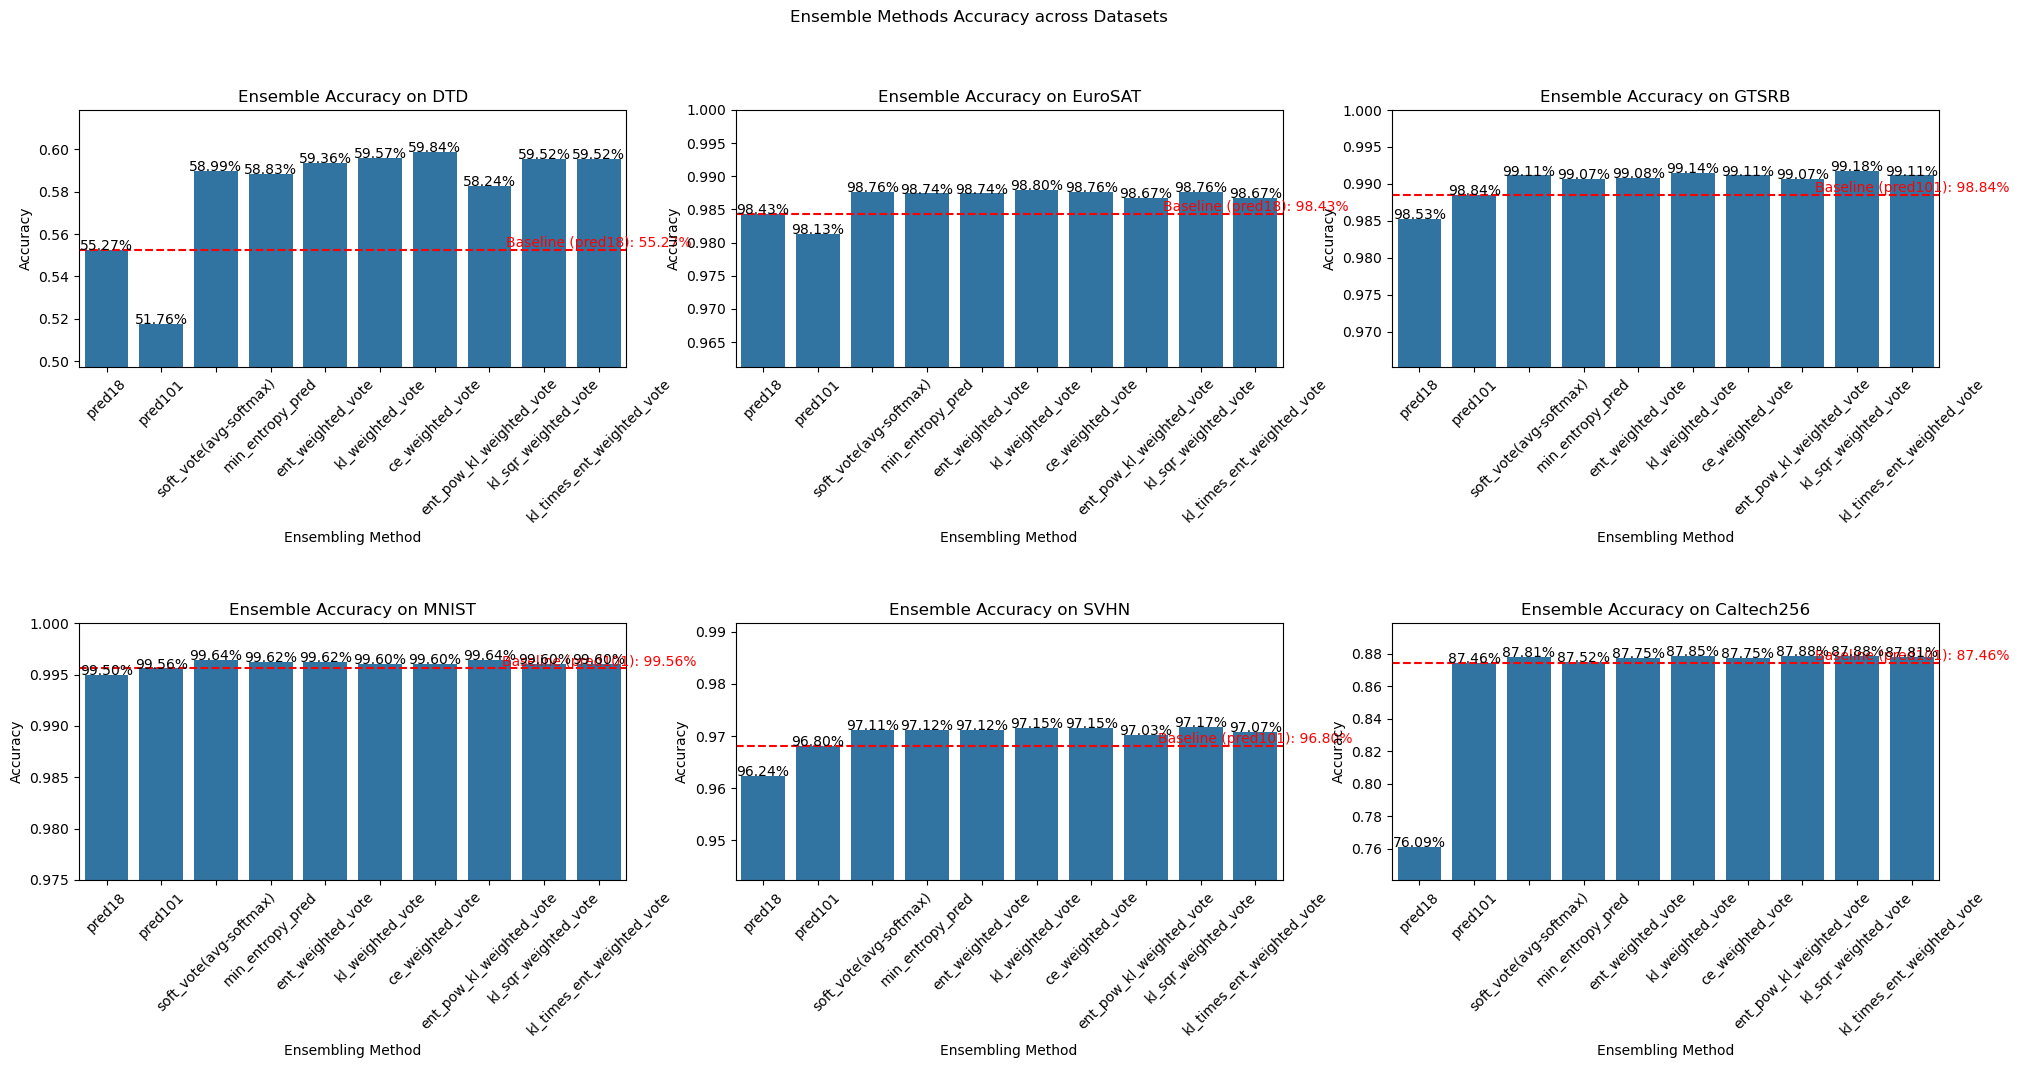

In [138]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

for i, ds in enumerate(datasets):
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    pred = pd.read_csv(f"prediction_{ds}.csv",index_col="Unnamed: 0").drop("pred50",axis=1)
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv")
    pred["soft_vote(avg-softmax)"] = soft_vote(df18, df101)
    pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
    pred["ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])
    pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
    pred["ce_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
    pred["ent_pow_kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
    pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
    pred["kl_times_ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]*unc_pred["ent_101"], unc_pred["kl_18_101"]*unc_pred["ent_18"])
    ax = axes[i // ncol, i % ncol]
    barplot(pred,ds,ax)
plt.subplots_adjust(hspace=1)
plt.suptitle("Ensemble Methods Accuracy across Datasets")
plt.savefig("artifacts/ensemble.png")
plt.show()

It's surprising that simply averaging predictions from a smaller model and a larger model is consistantly improving on accuracy, investigate: what kind of data is ensemble more likely to get right?
For this part let's focus on soft_vote since that's the simplest one

In [139]:
datasets = ["DTD","EuroSAT","GTSRB","MNIST","SVHN","Caltech256"]

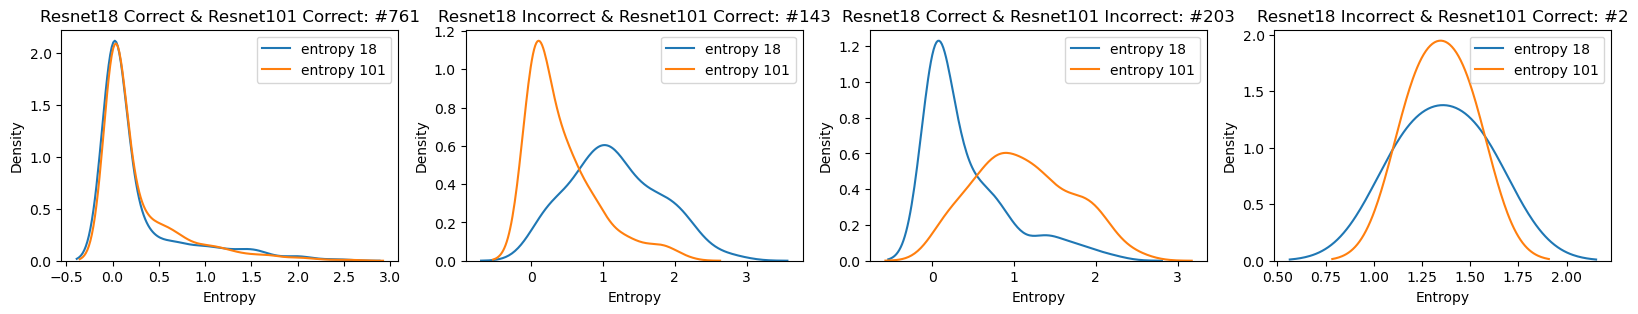

/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:42: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


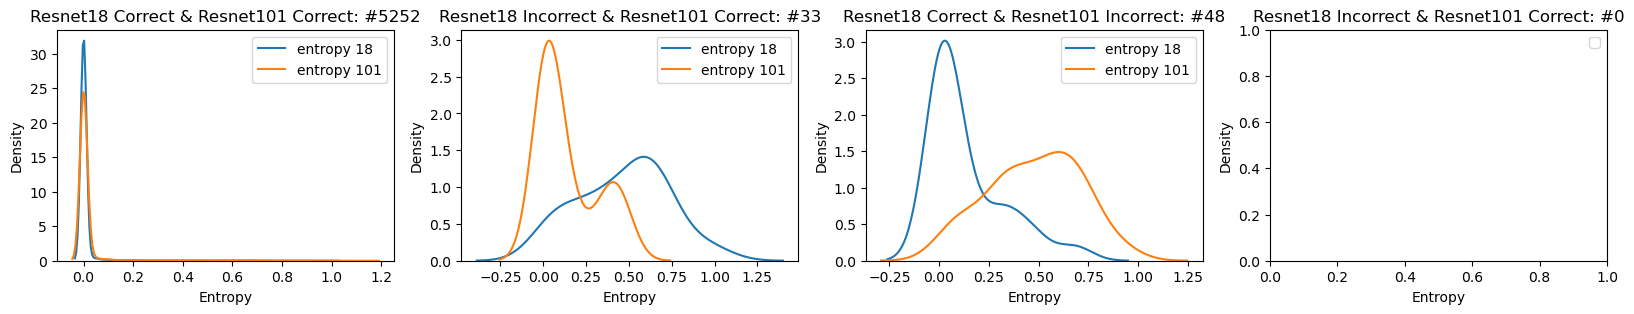

/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:42: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


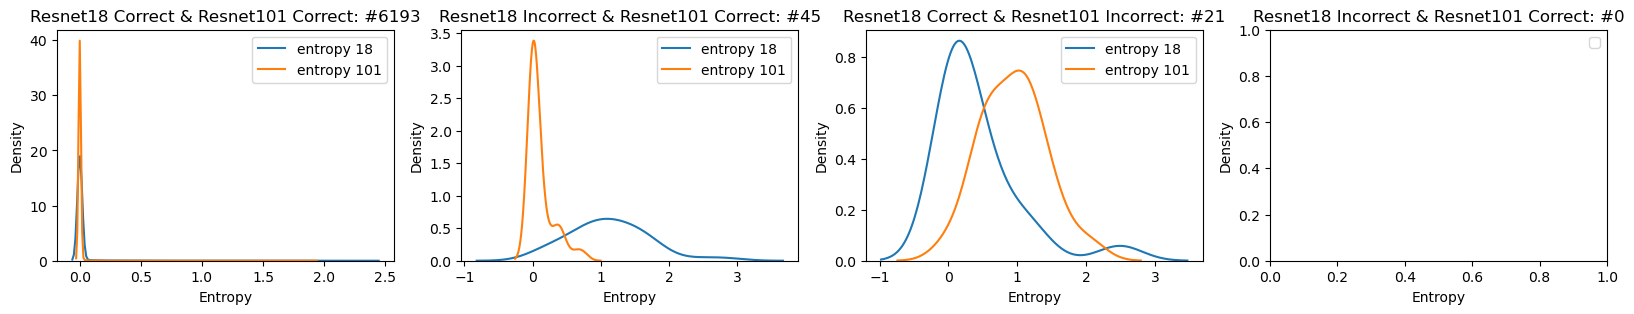

/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:42: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


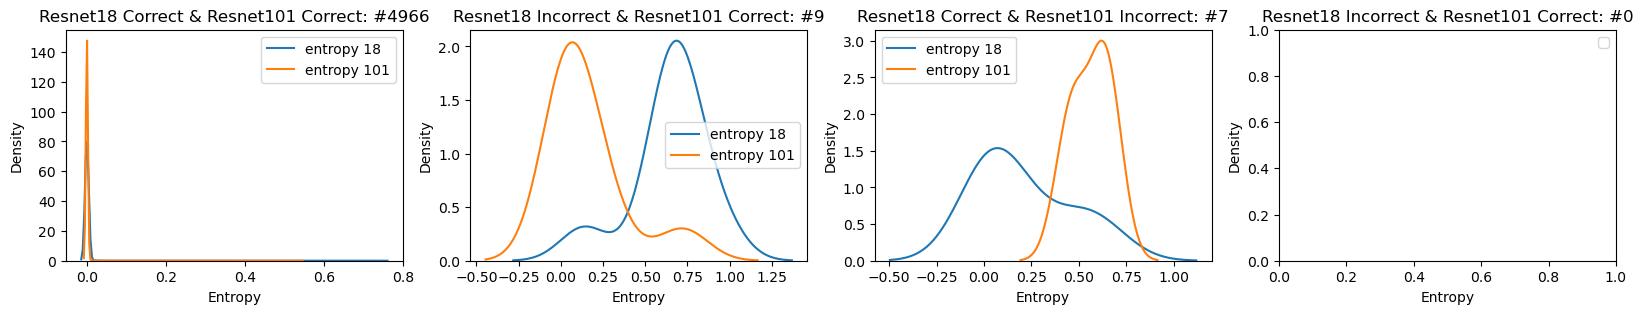

/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:42: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/1861416639.py:43: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


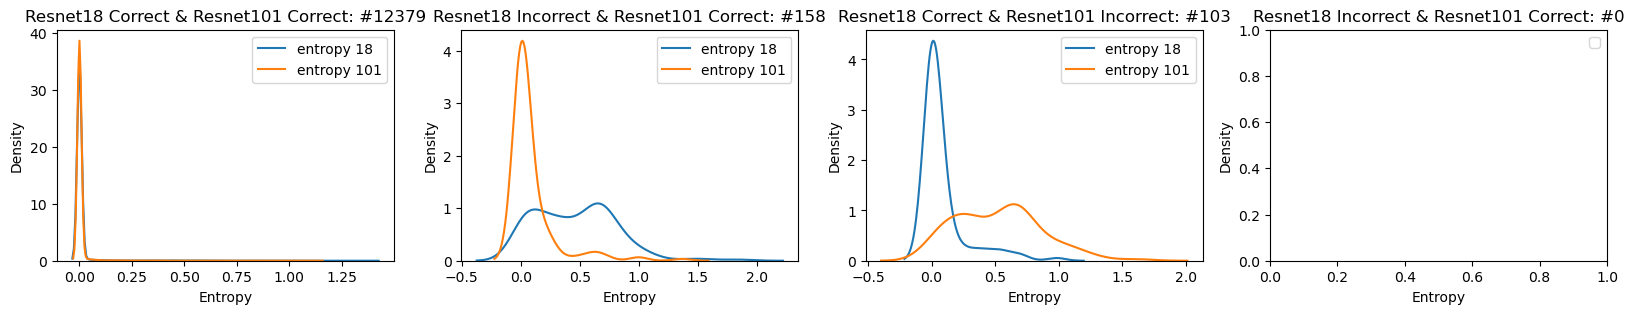

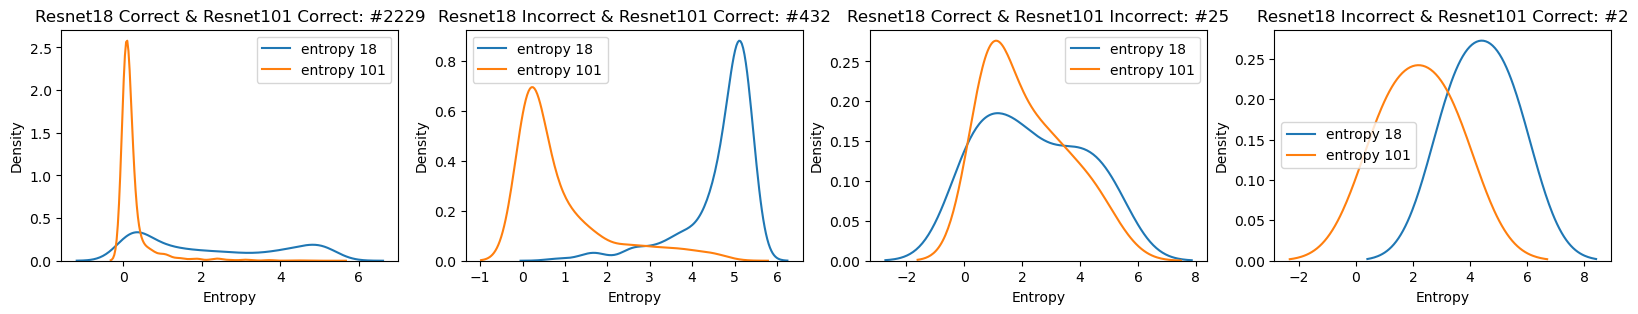

In [140]:
for i, ds in enumerate(datasets):
    fig, axes = plt.subplots(1, 4, figsize=(5*4, 3*1))
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    pred = pd.read_csv(f"prediction_{ds}.csv",index_col="Unnamed: 0").drop("pred50",axis=1)
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv")
    pred["soft_vote"] = soft_vote(df18, df101)
    # Resnet 18 right, Resnet 101 right, Soft Vote Right
    ax = axes[0]
    filtered_unc_pred = unc_pred[(pred["pred18"] == pred["target"]) & (pred["pred101"] == pred["target"]) & (pred["soft_vote"] == pred["target"])]
    sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
    sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
    filtered_len = filtered_unc_pred.shape[0]
    ax.legend()
    ax.set_title(f'Resnet18 Correct & Resnet101 Correct: #{filtered_len}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')
    # Resnet 18 wrong, Resnet 101 right, Soft Vote Right
    ax = axes[1]
    filtered_unc_pred = unc_pred[(pred["pred18"] != pred["target"]) & (pred["pred101"] == pred["target"]) & (pred["soft_vote"] == pred["target"])]
    sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
    sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
    filtered_len = filtered_unc_pred.shape[0]
    ax.legend()
    ax.set_title(f'Resnet18 Incorrect & Resnet101 Correct: #{filtered_len}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')
    # Resnet 18 right, Resnet 101 wrong, Soft Vote Right
    ax = axes[2]
    filtered_unc_pred = unc_pred[(pred["pred18"] == pred["target"]) & (pred["pred101"] != pred["target"]) & (pred["soft_vote"] == pred["target"])]
    sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
    sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
    filtered_len = filtered_unc_pred.shape[0]
    ax.legend()
    ax.set_title(f'Resnet18 Correct & Resnet101 Incorrect: #{filtered_len}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')
    # Resnet 18 wrong, Resnet 101 wrong, Soft Vote Right
    ax = axes[3]
    filtered_unc_pred = unc_pred[(pred["pred18"] != pred["target"]) & (pred["pred101"] != pred["target"]) & (pred["soft_vote"] == pred["target"])]
    sns.kdeplot(data=filtered_unc_pred, x="ent_18", label="entropy 18", ax=ax)
    sns.kdeplot(data=filtered_unc_pred, x="ent_101", label="entropy 101", ax=ax)
    filtered_len = filtered_unc_pred.shape[0]
    ax.legend()
    ax.set_title(f'Resnet18 Incorrect & Resnet101 Correct: #{filtered_len}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')

    plt.show()

In [141]:
def load_data(ds):
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    pred = pd.read_csv(f"prediction_{ds}.csv", index_col="Unnamed: 0").drop("pred50", axis=1)
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv")
    pred["soft_vote"] = soft_vote(df18, df101)
    return df18, df101, label, pred, unc_pred

In [142]:
def plot_kde(ax, data, title, label_suffix=''):
    sns.kdeplot(data=data, x="ent_18", label=f"entropy 18 {label_suffix}", ax=ax)
    sns.kdeplot(data=data, x="ent_101", label=f"entropy 101 {label_suffix}", ax=ax)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')

In [150]:
def plot_predictions(pred, unc_pred, axes_row):
    conditions = [
        (pred["pred18"] == pred["target"]) & (pred["pred101"] == pred["target"]) & (pred["soft_vote"] == pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] == pred["target"]) & (pred["soft_vote"] == pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] != pred["target"]) & (pred["soft_vote"] == pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] != pred["target"]) & (pred["soft_vote"] == pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] == pred["target"]) & (pred["soft_vote"] != pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] == pred["target"]) & (pred["soft_vote"] != pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] != pred["target"]) & (pred["soft_vote"] != pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] != pred["target"]) & (pred["soft_vote"] != pred["target"])
    ]
    
    titles = [
        '18 Cor & 101 Cor: #{}',
        '18 Incor & 101 Cor: #{}',
        '18 Cor & 101 Incor: #{}',
        '18 Incor & 101 Incor: #{}'
    ]
    
    for i, ax in enumerate(axes_row[:4]):
        condition = conditions[i]
        filtered_unc_pred = unc_pred[condition]
        temp_title = titles[i].format(filtered_unc_pred.shape[0])
        plot_kde(ax, filtered_unc_pred, temp_title, label_suffix='; Correct Soft Vote')
        condition = conditions[i + 4]
        filtered_unc_pred = unc_pred[condition]
        plot_kde(ax, filtered_unc_pred, temp_title+"||"+str(filtered_unc_pred.shape[0]), label_suffix='; Incorrect Soft Vote')


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/2150934656.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x="ent_18", label=f"entropy 18 {label_suffix}", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/2150934656.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x="ent_101", label=f"entropy 101 {label_suffix}", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/2150934656.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x="ent_18", label=f"entropy 18 {label_suffix}", ax=ax)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_34047/2150934656.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_sin

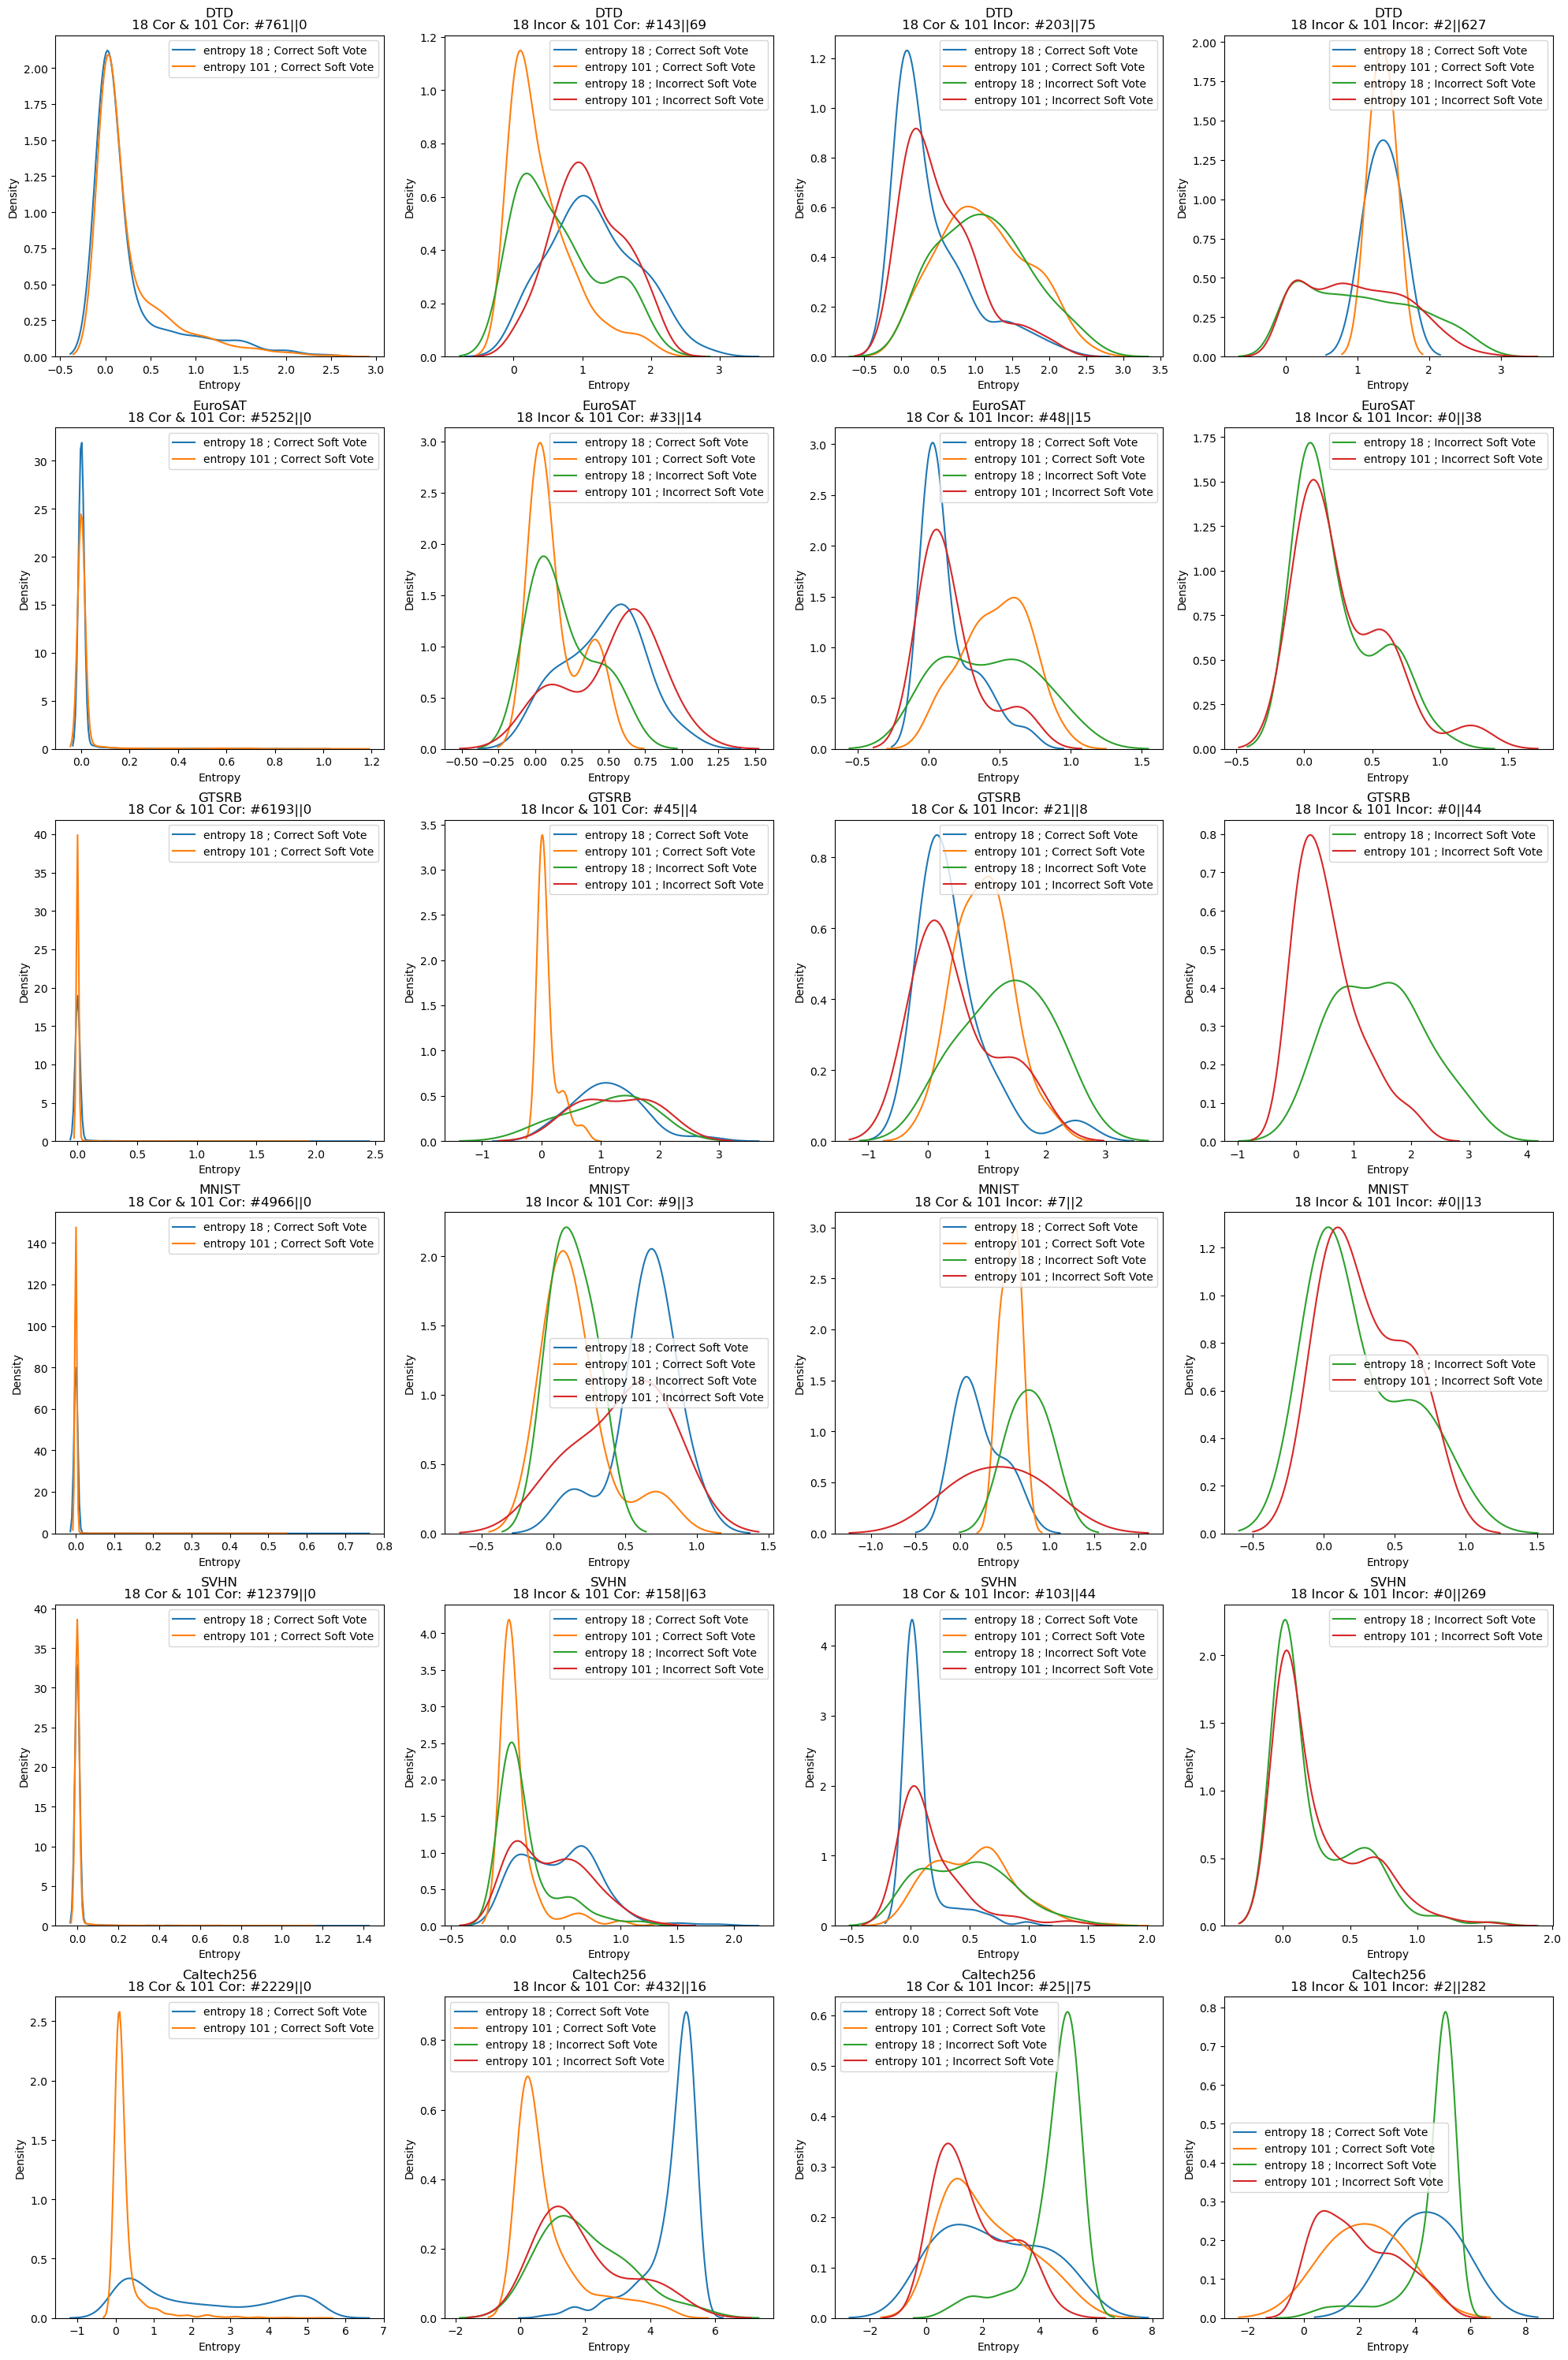

In [165]:
fig, axes = plt.subplots(len(datasets), 4, figsize=(20, 5 * len(datasets)))

# If there's only one dataset, axes will not be a 2D array, so handle that case
if len(datasets) == 1:
    axes = [axes]

for i, ds in enumerate(datasets):
    df18, df101, label, pred, unc_pred = load_data(ds)
    plot_predictions(pred, unc_pred, axes[i])
    for ax in axes[i]:
        ax.text(0.5, 1.05, ds, transform=ax.transAxes, ha='center', va='bottom', fontsize='large')

plt.tight_layout()
plt.savefig("artifacts/entropy_conditioned_on_ensemble.png")
plt.show()